<a href="https://colab.research.google.com/github/dpqhd01/medical_cap/blob/main/Colab_SiameseNetworkLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Device: cpu
데이터 크기: (805, 3)
                                              text_A  \
0  inclusion criteria:\n\n* patients presenting a...   
1  inclusion criteria:\n\n* histologically confir...   
2  inclusion criteria\n\n* signed and dated insti...   
3  inclusion criteria:\n\n* patients ≤18 years ol...   
4  inclusion criteria:\n\n* patients must have an...   

                     text_B  label  
0                dysarthria      0  
1        ulcerative colitis      1  
2  congestive heart failure      1  
3         abnormal bleeding      0  
4     myocardial infarction      1  
⚠️ 누락된 매핑 0건 제외됨.
입력 벡터 shape: (805, 1024)
데이터 분포: {np.float32(0.0): np.int64(200), np.float32(1.0): np.int64(605)}
✅ 데이터 균형 조정 완료: [605 605]


Epoch 1: 100%|██████████| 31/31 [00:01<00:00, 29.15it/s]


Epoch [1/30] | Loss: 0.6513 | F1: 0.8729
💾 모델 저장 (F1=0.8729)


Epoch 2: 100%|██████████| 31/31 [00:01<00:00, 28.86it/s]


Epoch [2/30] | Loss: 0.3727 | F1: 0.9219
💾 모델 저장 (F1=0.9219)


Epoch 3: 100%|██████████| 31/31 [00:01<00:00, 28.59it/s]


Epoch [3/30] | Loss: 0.2458 | F1: 0.9219
💾 모델 저장 (F1=0.9219)


Epoch 4: 100%|██████████| 31/31 [00:01<00:00, 29.05it/s]


Epoch [4/30] | Loss: 0.1769 | F1: 0.9312
💾 모델 저장 (F1=0.9312)


Epoch 5: 100%|██████████| 31/31 [00:01<00:00, 27.82it/s]


Epoch [5/30] | Loss: 0.1469 | F1: 0.9498
💾 모델 저장 (F1=0.9498)


Epoch 6: 100%|██████████| 31/31 [00:01<00:00, 26.41it/s]


Epoch [6/30] | Loss: 0.1438 | F1: 0.9453


Epoch 7: 100%|██████████| 31/31 [00:01<00:00, 19.89it/s]


Epoch [7/30] | Loss: 0.1078 | F1: 0.9494


Epoch 8: 100%|██████████| 31/31 [00:01<00:00, 19.44it/s]


Epoch [8/30] | Loss: 0.0916 | F1: 0.9344


Epoch 9: 100%|██████████| 31/31 [00:01<00:00, 27.87it/s]


Epoch [9/30] | Loss: 0.0837 | F1: 0.9470
🛑 Early stopping at epoch 9

=== 최종 Classification Report (Vector-LSTM) ===
              precision    recall  f1-score   support

         0.0     0.9381    0.9464    0.9422       112
         1.0     0.9535    0.9462    0.9498       130

    accuracy                         0.9463       242
   macro avg     0.9458    0.9463    0.9460       242
weighted avg     0.9463    0.9463    0.9463       242



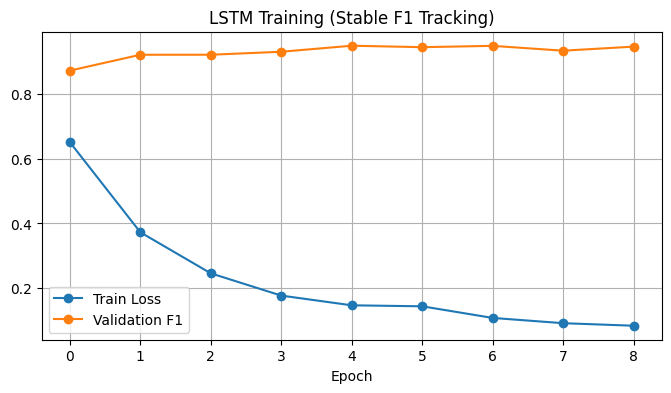

In [6]:
# ======================================
# 🔧 0. 라이브러리
# ======================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)

# ======================================
# 1️⃣ CSV 로드 + 전처리
# ======================================
emb_a = pd.read_csv('/content/trial_embeddings.csv')       # 임상시험
emb_b = pd.read_csv('/content/orpanet_embeddings.csv')     # 희귀질환
train_df = pd.read_csv('/content/training_data.csv')       # text_A, text_B, label

# 공백/소문자 정규화 (매칭률 향상)
for df, col in [(emb_a, 'original_text'), (emb_b, 'original_hpoterm'),
                (train_df, 'text_A'), (train_df, 'text_B')]:
    df[col] = df[col].astype(str).str.strip().str.lower()

print("데이터 크기:", train_df.shape)
print(train_df.head())

# ======================================
# 2️⃣ 매핑 딕셔너리 생성
# ======================================
vec_a = {row['original_text']: np.array(row.iloc[1:], dtype=np.float32) for _, row in emb_a.iterrows()}
vec_b = {row['original_hpoterm']: np.array(row.iloc[1:], dtype=np.float32) for _, row in emb_b.iterrows()}

# ======================================
# 3️⃣ 벡터 매칭
# ======================================
pairs, labels = [], []
missing = 0
for _, row in train_df.iterrows():
    a_vec = vec_a.get(row['text_A'])
    b_vec = vec_b.get(row['text_B'])
    if a_vec is None or b_vec is None:
        missing += 1
        continue
    pairs.append(np.concatenate([a_vec, b_vec]))
    labels.append(row['label'])

print(f"⚠️ 누락된 매핑 {missing}건 제외됨.")
X = np.vstack(pairs)
y = np.array(labels, dtype=np.float32)
print("입력 벡터 shape:", X.shape)

# ======================================
# 4️⃣ 데이터 균형 조정
# ======================================
unique, counts = np.unique(y, return_counts=True)
print("데이터 분포:", dict(zip(unique, counts)))

if len(counts) == 2 and counts[0] != counts[1]:
    from sklearn.utils import resample
    pos_idx = np.where(y == 1)[0]
    neg_idx = np.where(y == 0)[0]
    if len(pos_idx) > 0 and len(neg_idx) > 0:
        if len(pos_idx) > len(neg_idx):
            neg_up = resample(neg_idx, replace=True, n_samples=len(pos_idx), random_state=42)
            idx_bal = np.concatenate([pos_idx, neg_up])
        else:
            pos_up = resample(pos_idx, replace=True, n_samples=len(neg_idx), random_state=42)
            idx_bal = np.concatenate([pos_up, neg_idx])
        X, y = X[idx_bal], y[idx_bal]
        print("✅ 데이터 균형 조정 완료:", np.unique(y, return_counts=True)[1])

# ======================================
# 5️⃣ Dataset / DataLoader
# ======================================
class VectorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_loader = DataLoader(VectorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(VectorDataset(X_test, y_test), batch_size=32, shuffle=False)

# ======================================
# 6️⃣ LSTM 인코더 정의
# ======================================
class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        # x: (batch, input_dim)
        x = x.unsqueeze(1)  # (batch, seq_len=1, input_dim)
        _, (h, _) = self.lstm(x)
        out = self.fc(h[-1])
        return out.squeeze()

input_dim = X.shape[1]
model = LSTMEncoder(input_dim=input_dim).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

# ======================================
# 7️⃣ 학습 루프 (F1 저장 강화)
# ======================================
train_loss_list, val_f1_list = [], []
best_f1, patience = 0, 4

for epoch in range(30):
    model.train()
    total_loss = 0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_loss_list.append(avg_loss)

    # Validation
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            probs = torch.sigmoid(model(xb)).cpu().numpy()
            preds.extend((probs > 0.5).astype(int))
            trues.extend(yb.numpy())
    f1 = f1_score(trues, preds, zero_division=0)
    val_f1_list.append(f1)
    print(f"Epoch [{epoch+1}/30] | Loss: {avg_loss:.4f} | F1: {f1:.4f}")
    scheduler.step(f1)

    # 항상 저장 (F1=0이어도)
    if f1 >= best_f1:
        best_f1 = f1
        patience = 4
        torch.save(model.state_dict(), "/content/best_vec_lstm.pt")
        print(f"💾 모델 저장 (F1={best_f1:.4f})")
    else:
        patience -= 1
        if patience == 0:
            print("🛑 Early stopping at epoch", epoch+1)
            break

# ======================================
# 8️⃣ 최종 평가
# ======================================
model.load_state_dict(torch.load("/content/best_vec_lstm.pt"))
model.eval()
preds, trues = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        probs = torch.sigmoid(model(xb)).cpu().numpy()
        preds.extend((probs > 0.5).astype(int))
        trues.extend(yb.numpy())

print("\n=== 최종 Classification Report (Vector-LSTM) ===")
print(classification_report(trues, preds, digits=4))

plt.figure(figsize=(8,4))
plt.plot(train_loss_list, label="Train Loss", marker='o')
plt.plot(val_f1_list, label="Validation F1", marker='o')
plt.title("LSTM Training (Stable F1 Tracking)")
plt.xlabel("Epoch")
plt.legend()
plt.grid()
plt.show()


샴 네트워크 상 인코더(LSTM)

✅ Device: cpu
⚠️ 누락된 매핑 0건 제외됨.
입력 shape: (805, 512) (805, 512)
데이터 분포: {np.float32(0.0): np.int64(200), np.float32(1.0): np.int64(605)}
✅ 데이터 균형 조정 완료: [605 605]


Epoch 1: 100%|██████████| 31/31 [00:01<00:00, 22.64it/s]


Epoch [1/30] | Loss: 0.6906 | F1: 0.7763
💾 모델 저장 (F1=0.7763)


Epoch 2: 100%|██████████| 31/31 [00:01<00:00, 16.70it/s]


Epoch [2/30] | Loss: 0.5672 | F1: 0.9183
💾 모델 저장 (F1=0.9183)


Epoch 3: 100%|██████████| 31/31 [00:01<00:00, 17.26it/s]


Epoch [3/30] | Loss: 0.3193 | F1: 0.9270
💾 모델 저장 (F1=0.9270)


Epoch 4: 100%|██████████| 31/31 [00:01<00:00, 22.35it/s]


Epoch [4/30] | Loss: 0.3011 | F1: 0.8746


Epoch 5: 100%|██████████| 31/31 [00:01<00:00, 23.21it/s]


Epoch [5/30] | Loss: 0.2620 | F1: 0.9434
💾 모델 저장 (F1=0.9434)


Epoch 6: 100%|██████████| 31/31 [00:01<00:00, 22.89it/s]


Epoch [6/30] | Loss: 0.1849 | F1: 0.9398


Epoch 7: 100%|██████████| 31/31 [00:01<00:00, 22.33it/s]


Epoch [7/30] | Loss: 0.1619 | F1: 0.9348


Epoch 8: 100%|██████████| 31/31 [00:01<00:00, 22.59it/s]


Epoch [8/30] | Loss: 0.1434 | F1: 0.9434
💾 모델 저장 (F1=0.9434)


Epoch 9: 100%|██████████| 31/31 [00:01<00:00, 22.94it/s]


Epoch [9/30] | Loss: 0.1168 | F1: 0.9506
💾 모델 저장 (F1=0.9506)


Epoch 10: 100%|██████████| 31/31 [00:01<00:00, 18.94it/s]


Epoch [10/30] | Loss: 0.0977 | F1: 0.9538
💾 모델 저장 (F1=0.9538)


Epoch 11: 100%|██████████| 31/31 [00:01<00:00, 16.08it/s]


Epoch [11/30] | Loss: 0.0825 | F1: 0.9575
💾 모델 저장 (F1=0.9575)


Epoch 12: 100%|██████████| 31/31 [00:01<00:00, 21.35it/s]


Epoch [12/30] | Loss: 0.0747 | F1: 0.9502


Epoch 13: 100%|██████████| 31/31 [00:01<00:00, 22.92it/s]


Epoch [13/30] | Loss: 0.0770 | F1: 0.9494


Epoch 14: 100%|██████████| 31/31 [00:01<00:00, 22.25it/s]


Epoch [14/30] | Loss: 0.0655 | F1: 0.9470


Epoch 15: 100%|██████████| 31/31 [00:01<00:00, 23.23it/s]


Epoch [15/30] | Loss: 0.0617 | F1: 0.9502
🛑 Early stopping at epoch 15

=== 최종 Classification Report (Siamese LSTM) ===
              precision    recall  f1-score   support

         0.0     0.9469    0.9554    0.9511       112
         1.0     0.9612    0.9538    0.9575       130

    accuracy                         0.9545       242
   macro avg     0.9541    0.9546    0.9543       242
weighted avg     0.9546    0.9545    0.9546       242



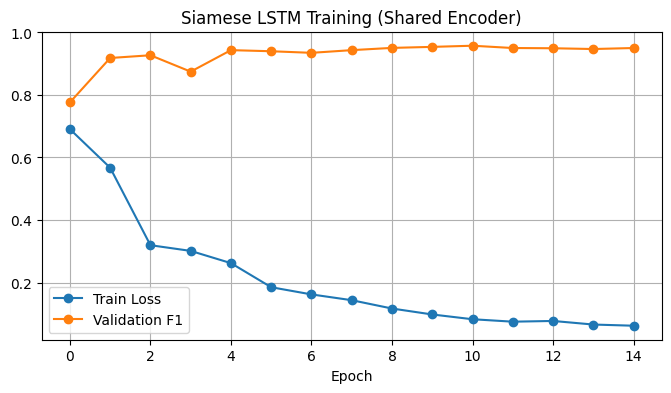

In [7]:
# ======================================
# 🔧 0. 라이브러리 + 재현성 설정
# ======================================
import os, random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- 재현성 보장 ---
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True, warn_only=True)
os.environ["PYTHONHASHSEED"] = str(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)

# ======================================
# 1️⃣ 데이터 로드 + 전처리
# ======================================
emb_a = pd.read_csv('/content/trial_embeddings.csv')       # 임상시험
emb_b = pd.read_csv('/content/orpanet_embeddings.csv')     # 희귀질환
train_df = pd.read_csv('/content/training_data.csv')       # text_A, text_B, label

for df, col in [(emb_a, 'original_text'), (emb_b, 'original_hpoterm'),
                (train_df, 'text_A'), (train_df, 'text_B')]:
    df[col] = df[col].astype(str).str.strip().str.lower()

vec_a = {row['original_text']: np.array(row.iloc[1:], dtype=np.float32) for _, row in emb_a.iterrows()}
vec_b = {row['original_hpoterm']: np.array(row.iloc[1:], dtype=np.float32) for _, row in emb_b.iterrows()}

pairs_a, pairs_b, labels = [], [], []
missing = 0
for _, row in train_df.iterrows():
    a_vec = vec_a.get(row['text_A'])
    b_vec = vec_b.get(row['text_B'])
    if a_vec is None or b_vec is None:
        missing += 1
        continue
    pairs_a.append(a_vec)
    pairs_b.append(b_vec)
    labels.append(row['label'])

print(f"⚠️ 누락된 매핑 {missing}건 제외됨.")
X_a, X_b, y = np.vstack(pairs_a), np.vstack(pairs_b), np.array(labels, dtype=np.float32)
print("입력 shape:", X_a.shape, X_b.shape)

# ======================================
# 2️⃣ 데이터 균형 조정
# ======================================
unique, counts = np.unique(y, return_counts=True)
print("데이터 분포:", dict(zip(unique, counts)))

if len(counts) == 2 and counts[0] != counts[1]:
    pos_idx = np.where(y == 1)[0]
    neg_idx = np.where(y == 0)[0]
    if len(pos_idx) > len(neg_idx):
        neg_up = resample(neg_idx, replace=True, n_samples=len(pos_idx), random_state=42)
        idx_bal = np.concatenate([pos_idx, neg_up])
    else:
        pos_up = resample(pos_idx, replace=True, n_samples=len(neg_idx), random_state=42)
        idx_bal = np.concatenate([pos_up, neg_idx])
    X_a, X_b, y = X_a[idx_bal], X_b[idx_bal], y[idx_bal]
    print("✅ 데이터 균형 조정 완료:", np.unique(y, return_counts=True)[1])

# ======================================
# 3️⃣ Dataset / DataLoader
# ======================================
class SiameseVectorDataset(Dataset):
    def __init__(self, X_a, X_b, y):
        self.X_a = torch.tensor(X_a, dtype=torch.float32)
        self.X_b = torch.tensor(X_b, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X_a)
    def __getitem__(self, idx): return self.X_a[idx], self.X_b[idx], self.y[idx]

X_a_train, X_a_test, X_b_train, X_b_test, y_train, y_test = train_test_split(
    X_a, X_b, y, test_size=0.2, random_state=42
)
train_loader = DataLoader(SiameseVectorDataset(X_a_train, X_b_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(SiameseVectorDataset(X_a_test, X_b_test, y_test), batch_size=32, shuffle=False)

# ======================================
# 4️⃣ Siamese LSTM 인코더 정의
# ======================================
class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
    def forward(self, x):
        x = x.unsqueeze(1)                # (batch, seq_len=1, input_dim)
        _, (h, _) = self.lstm(x)          # h[-1]: (batch, hidden_dim)
        return h[-1]

class SiameseLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=256):
        super().__init__()
        self.encoder = LSTMEncoder(input_dim, hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )
    def forward(self, x1, x2):
        h1 = self.encoder(x1)
        h2 = self.encoder(x2)
        diff = torch.abs(h1 - h2)   # |h1 - h2| : 유사도 학습 핵심
        out = self.fc(diff)
        return out.squeeze()

# ======================================
# 5️⃣ 학습 준비
# ======================================
input_dim = X_a.shape[1]
model = SiameseLSTM(input_dim=input_dim).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

train_loss_list, val_f1_list = [], []
best_f1, patience = 0, 4

# ======================================
# 6️⃣ 학습 루프
# ======================================
for epoch in range(30):
    model.train()
    total_loss = 0
    for a, b, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        a, b, yb = a.to(device), b.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(a, b)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_loss_list.append(avg_loss)

    # Validation
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for a, b, yb in test_loader:
            a, b = a.to(device), b.to(device)
            probs = torch.sigmoid(model(a, b)).cpu().numpy()
            preds.extend((probs > 0.5).astype(int))
            trues.extend(yb.numpy())
    f1 = f1_score(trues, preds, zero_division=0)
    val_f1_list.append(f1)
    print(f"Epoch [{epoch+1}/30] | Loss: {avg_loss:.4f} | F1: {f1:.4f}")
    scheduler.step(f1)

    if f1 >= best_f1:
        best_f1 = f1
        patience = 4
        torch.save(model.state_dict(), "/content/best_siamese_lstm.pt")
        print(f"💾 모델 저장 (F1={best_f1:.4f})")
    else:
        patience -= 1
        if patience == 0:
            print("🛑 Early stopping at epoch", epoch+1)
            break

# ======================================
# 7️⃣ 평가
# ======================================
model.load_state_dict(torch.load("/content/best_siamese_lstm.pt"))
model.eval()
preds, trues = [], []
with torch.no_grad():
    for a, b, yb in test_loader:
        a, b = a.to(device), b.to(device)
        probs = torch.sigmoid(model(a, b)).cpu().numpy()
        preds.extend((probs > 0.5).astype(int))
        trues.extend(yb.numpy())

print("\n=== 최종 Classification Report (Siamese LSTM) ===")
print(classification_report(trues, preds, digits=4))

plt.figure(figsize=(8,4))
plt.plot(train_loss_list, label="Train Loss", marker='o')
plt.plot(val_f1_list, label="Validation F1", marker='o')
plt.title("Siamese LSTM Training (Shared Encoder)")
plt.xlabel("Epoch")
plt.legend()
plt.grid()
plt.show()
